<a href="https://colab.research.google.com/github/sushirito/Hg2/blob/main/2D_Pore_Reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    func=robin_func,
    on_boundary=boundary_solid
)


def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)  # grad^2(u) = 0

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=200,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1],
    "tanh",
    "Glorot normal",
)

# 5. Model Compilation
model = dde.Model(data, net)
model.compile("adam", lr=0.001)


losshistory, train_state = model.train(
    iterations=10000,
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.067710 s

'compile' took 0.993845 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.22e-02, 2.59e-02, 2.32e-02]    [5.37e-02, 2.59e-02, 2.32e-02]    []  
1000      [4.10e-04, 2.72e-03, 3.49e-04]    [2.52e-04, 2.72e-03, 3.49e-04]    []  
2000      [4.71e-04, 1.03e-03, 3.61e-04]    [4.54e-04, 1.03e-03, 3.61e-04]    []  
3000      [2.13e-04, 3.97e-04, 2.81e-04]    [1.44e-04, 3.97e-04, 2.81e-04]    []  
4000      [1.10e-04, 1.83e-04, 2.37e-04]    [6.78e-05, 1.83e-04, 2.37e-04]    []  
5000      [6.57e-05, 1.40e-04, 2.39e-04]    [3.44e-05, 1.40e-04, 2.39e-04]    []  
6000      [6.54e-05, 1.36e-04, 3.00e-04]    [4.96e-05, 1.36e-04, 3.00e-04]    []  
7000      [1.29e-04, 1.57e-04, 2.20e-04]    [1.34e-04, 1.57e-04, 2.20e-04]    []  
8000      [2.39e-05, 1.18e-04, 2.35e-04]    [1.66e-05, 1.18e-04, 2.35e-04]    []  
9000      [1.83e-05, 1.18e-04, 2.

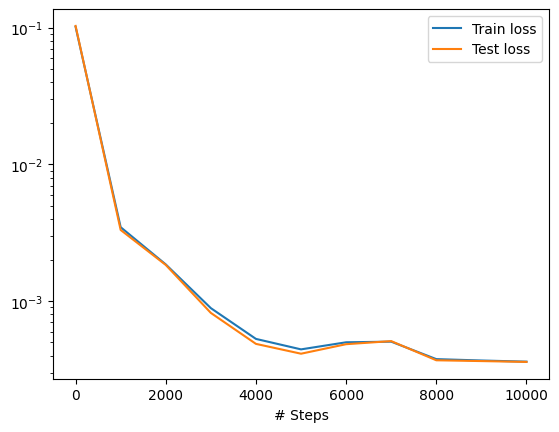

In [64]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0
T = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

time_domain = dde.geometry.TimeDomain(0, T)

geomtime = dde.geometry.GeometryXTime(fluid_domain, time_domain)

def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x[:2])

robin_bc = dde.icbc.RobinBC(
    geomtime, func=robin_func, on_boundary=boundary_solid
)

def initial_func(x):
    return 0.0

ic = dde.IC(geomtime, initial_func, lambda x, _: np.isclose(x[2], 0))

def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    du_dt = dde.grad.jacobian(u, x, i=0, j=2)
    return du_dt - D * (d2u_dx2 + d2u_dy2)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [robin_bc, ic],
    num_domain=1000,
    num_boundary=100,
    num_initial=200,
    num_test=200,
)

net = dde.nn.FNN([3] + [50] * 4 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)
model.compile("adam", lr=0.001)

losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
